#  Polarizer optimization

In [1]:
# Add mitsuba and enoki to PATH (this shouldn't be necessary)
import sys
sys.path.append('../../../build/python')

In [2]:
from matplotlib import pyplot as plt

import enoki as ek 
import mitsuba
mitsuba.set_variant('cuda_ad_rgb_polarized')

In [3]:
from mitsuba.core.xml import load_file
from mitsuba.python.util import traverse

# TODO would be great no to have to do this!
ek.set_flag(ek.JitFlag.LoopRecord,  False)

# Load scene
scene = load_file('../scenes/polarizers.xml', res=128, max_depth=3)
params = traverse(scene)

2021-09-17 11:13:32 INFO main [xml.cpp:1261] Loading XML file "../scenes/polarizers.xml" ..

2021-09-17 11:13:32 INFO main [xml.cpp:1262] Using variant "cuda_ad_rgb_polarized"

2021-09-17 11:13:32 INFO main [Scene] Building scene in OptiX ..

2021-09-17 11:13:32 INFO main [Scene] OptiX ready. (took 84ms)

In [4]:
# Render image: the two filters are aligned and let linearly polarized light through
integrator = scene.integrator()
image_init = integrator.render(scene, seed=0, spp=8)

2021-09-17 11:13:32 INFO main [SamplingIntegrator] Start rendering...

2021-09-17 11:13:33 INFO main [SamplingIntegrator] Rendering finished. (took 218ms)

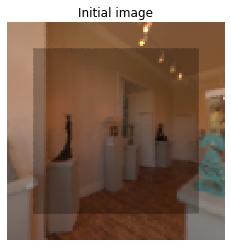

In [5]:
from mitsuba.python.util import write_bitmap, convert_to_bitmap

def show_image(img, title):
    plt.imshow(convert_to_bitmap(img, crop_size)); plt.axis('off'); plt.title(title);
    plt.show()

# Show image
crop_size = scene.sensors()[0].film().crop_size()
show_image(image_init, 'Initial image')
write_bitmap('out_init.png', image_init, crop_size)

In [6]:
from mitsuba.python.ad.optimizers import Adam
from mitsuba.core import Float, Vector3f, Transform4f

# Setup optimizer and differentiable rotation angle that gets applied to mesh vertices

key = 'filter2.vertex_positions'
params.keep([key])
positions_init = ek.unravel(Vector3f, ek.detach(params[key]))

opt = Adam(lr=1.0, params=params)
opt['rotation'] = Float(0.0)

transform = Transform4f.rotate(-Vector3f(0, 0, 1), opt['rotation'])
positions_new = transform @ positions_init
params[key] = ek.ravel(positions_new)

opt.update()

In [7]:
from mitsuba.core import Thread, LogLevel

# Optimization loop

Thread.thread().logger().set_log_level(LogLevel.Warn)

angles = []
losses = []

for it in range(120):
    scene.sensors()[0].sampler().seed(0)
    # Differentiable rendering
    # TODO: render separately to do unbiased=True
    image = integrator.render(scene, seed=it, spp=1)
    
#     write_bitmap('out_%03i.png' % it, image, crop_size)
    
    # Objective: no comparison against a reference, the goal is simply to make the image darker
    ob_val = ek.hsum_async(image) / len(image)
    
    # Backpropagate loss to input parameters
    ek.backward(ob_val)
    
    # Optimizer: take a gradient setp
    opt.step()
    
    # Apply rotation
    transform = Transform4f.rotate(-Vector3f(0, 0, 1), opt['rotation'])
    positions_new = transform @ positions_init
    params[key] = ek.ravel(positions_new)
    
    # Optimizer: update the scene parameters
    opt.update()
    
    print('Iteration %03i, rot: %.5f, loss: %f:' % (it, opt['rotation'][0], ob_val[0]))
    angles.append(opt['rotation'][0])
    losses.append(ob_val[0])
    
print('Optimization complete!')

Iteration 000, rot: -0.98025, loss: 0.107042:
Iteration 001, rot: -1.93759, loss: 0.107074:
Iteration 002, rot: -2.89224, loss: 0.106835:
Iteration 003, rot: -3.85136, loss: 0.106661:
Iteration 004, rot: -4.81822, loss: 0.106880:
Iteration 005, rot: -5.79462, loss: 0.106726:
Iteration 006, rot: -6.78176, loss: 0.106831:
Iteration 007, rot: -7.78037, loss: 0.106664:
Iteration 008, rot: -8.79091, loss: 0.106246:
Iteration 009, rot: -9.81368, loss: 0.106347:
Iteration 010, rot: -10.84891, loss: 0.105985:
Iteration 011, rot: -11.89667, loss: 0.106010:
Iteration 012, rot: -12.95701, loss: 0.105434:
Iteration 013, rot: -14.02992, loss: 0.105494:
Iteration 014, rot: -15.11534, loss: 0.105310:
Iteration 015, rot: -16.21318, loss: 0.104808:
Iteration 016, rot: -17.32327, loss: 0.105039:
Iteration 017, rot: -18.44548, loss: 0.104357:
Iteration 018, rot: -19.57958, loss: 0.104128:
Iteration 019, rot: -20.72530, loss: 0.103784:
Iteration 020, rot: -21.88236, loss: 0.103374:
Iteration 021, rot: -23

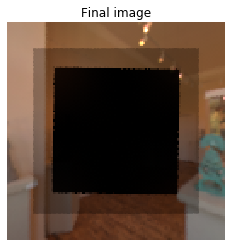

In [8]:
image_final = integrator.render(scene, seed=0, spp=8)
show_image(image_final, 'Final image')
write_bitmap('out_final.png', image_final, crop_size)

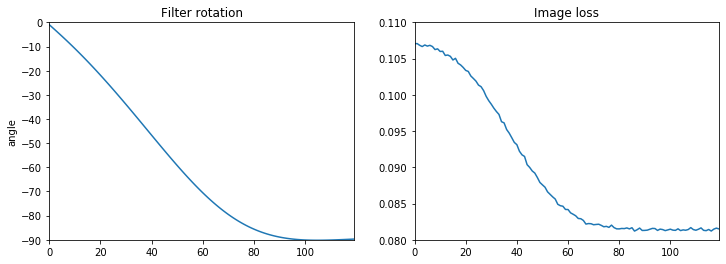

In [9]:
# Plot angles and loss

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ax[0].plot(angles);
ax[0].set_ylabel('angle'); ax[0].set_title('Filter rotation');
ax[0].set_xlim([0, 119]); ax[0].set_ylim([-90, 0])


ax[1].plot(losses); ax[1].set_title('Image loss')
ax[1].set_xlim([0, 119]); ax[1].set_ylim([0.08, 0.11])

plt.show()